# Домашнее задание 4

В последнем практическом задании мы потренируемся в построении VaR-кривой для небольшого портфеля.

In [1]:
import yfinance as yf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as ss
from copulae.archimedean import ClaytonCopula, FrankCopula, GumbelCopula 
plt.style.use("bmh")
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['figure.figsize'] = 16,10

import warnings
warnings.filterwarnings("ignore")

### 1) Загрузка данных (0.5 балла)

* Представьте, что вы инвестор и собираете инвестиционный портфель. 

* Загрузите данные по трём любым акциям и двум любым валютам за последние 10 лет. Акции и валюты выберите на ваш вкус, но интереснее будет взять что-то кроме евро/доллара/акций гугла.

* Можно использовать YachooFinance либо другие источники при желании.




In [2]:
stock_list = ['INTC', 'NVDA', 'BAC', 'JPYUSD=X', 'CHFUSD=X']

prices = yf.download(stock_list,
            start = '2012-01-01',
            end='2022-01-01')
prices.index = prices.index.to_period(freq='d')
prices = prices['Adj Close'].dropna()

[*********************100%***********************]  5 of 5 completed


### 2) Преобразование данных (0.2 балла)

Переведите цены в доходности. Можно использовать разности или процентные изменения на выбор.

In [3]:
returns = prices.pct_change().dropna()

### 3) Визуализация. (2 балла)


* Изобразите парные диаграммы рассеяния (scatterplot) для всех комбинаций инструментов. В каких парах наблюдается связь, а в каких нет? Кратко интерпретируйте зависимость по одному примеру из предыдущего вопроса (один где есть зависимость, другой где нет). Если во всех парах есть зависимость (или во всех нет), то достаточно одного примера. (0.5 балла)

* Изобразите гистограмму распределения каждого инструмента, наложив на неё оценённое нормальное распределение. Что можно сказать о характеристиках распределения доходностей (скошенность и тяжесть хвостов)? (1 балл).

* В качестве весов портфеля используйте веса на момент покупки (как в семинаре). Изобразите  гистограмму распределения доходностей портфеля, наложив на неё оценённое нормальное распределение. Что можно сказать о характеристиках распределения доходностей (скошенность и тяжесть хвостов)? (0.5 балла)

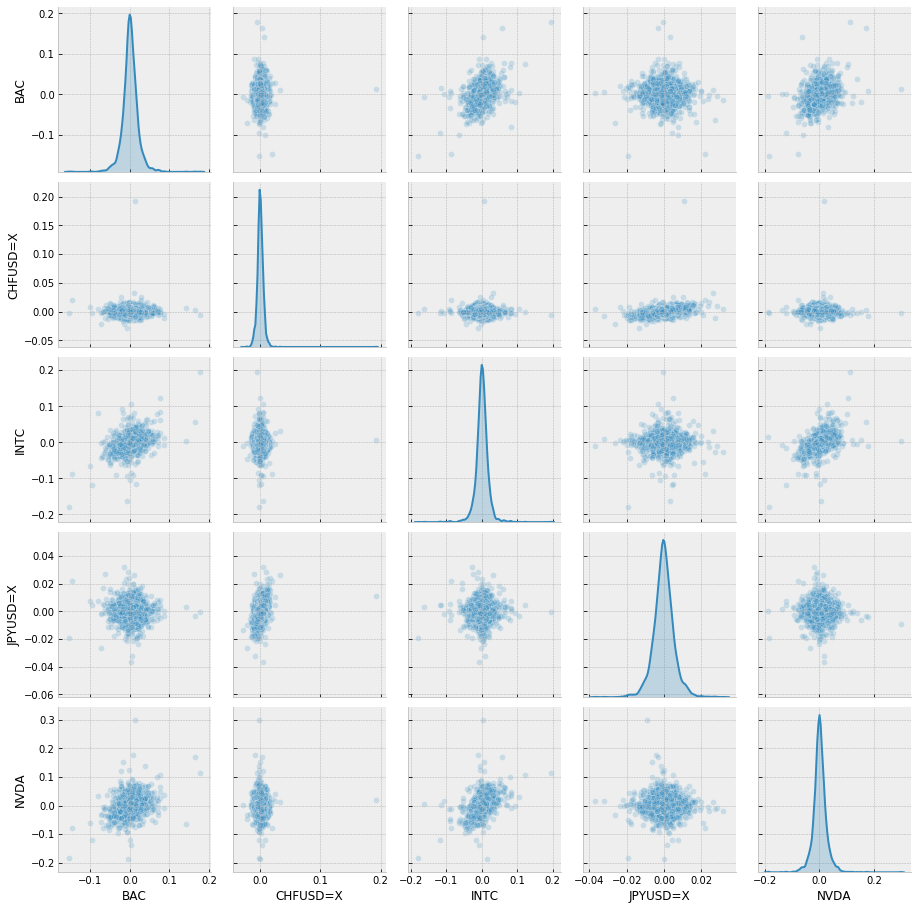

In [4]:
sns.pairplot(returns, diag_kind='kde', plot_kws = {'alpha':0.2})

Акции находятся в зависимости друг с другом. Валюты же не находятся в зависимости ни друг с другом, ни с другими акциями. Взаимозависимость акций понятна: рассматриваются акции технологических компаний, движение доходности которых подчиняется одним и тем же принципам. 

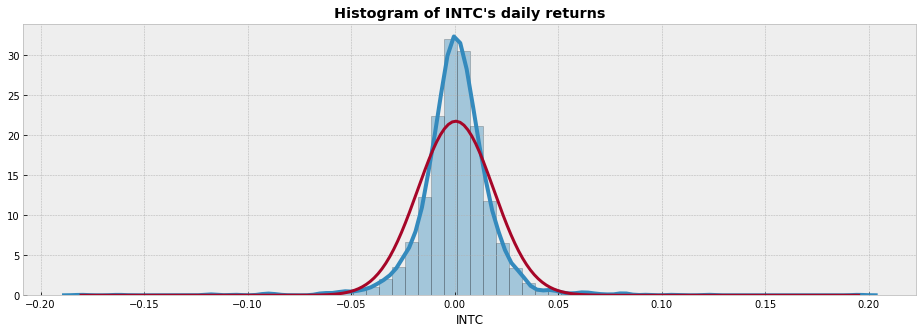

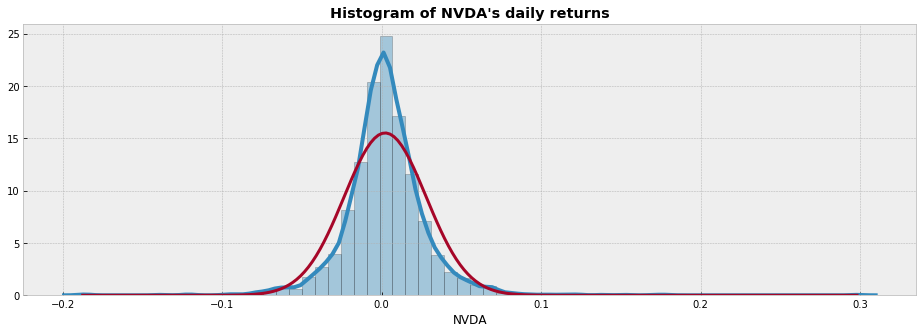

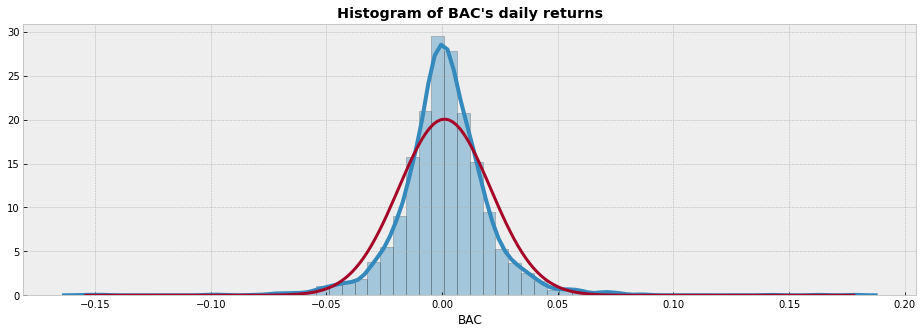

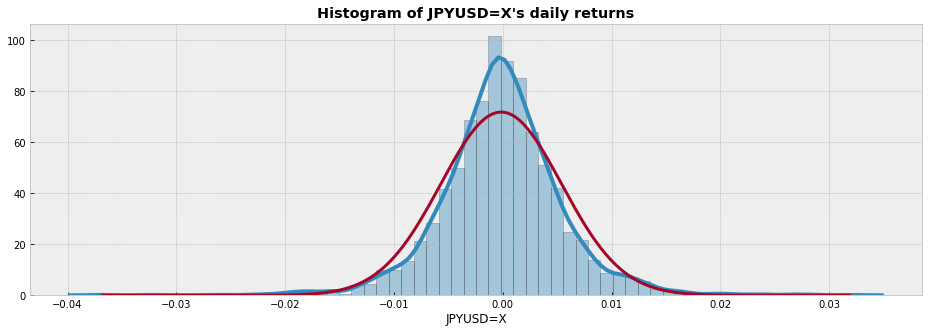

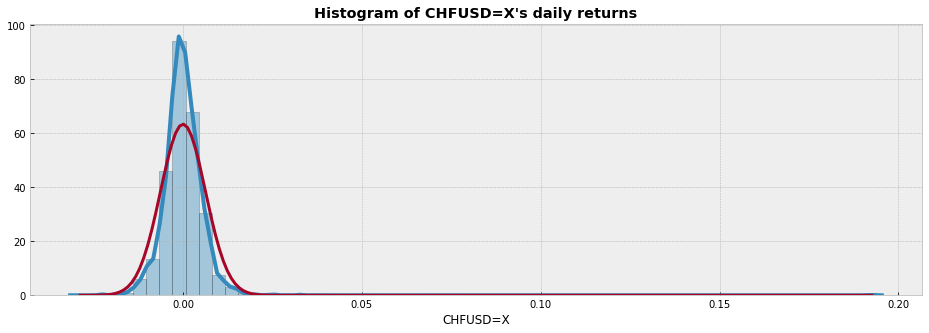

In [5]:
for stock in stock_list:
    fig = plt.figure(figsize=(16, 5))

    x = np.linspace(returns[stock].min(), returns[stock].max(), 200)

    sns.distplot(returns[stock], hist=True, kde=True, 
                 bins=60,
                 hist_kws={'edgecolor':'black'},
                 kde_kws={'linewidth': 4})

    params_norm = ss.norm.fit(returns[stock])
    y_pdf = ss.norm.pdf(x, *params_norm)
    plt.plot(x, y_pdf, linewidth=3)

    plt.title(f"Histogram of {stock}'s daily returns", weight="bold")

    plt.show()

скошенность отсутствует, хвосты каждого распределения тяжее нормального.

In [6]:
w = 1 / prices.iloc[0]
w = w / w.sum()
portfolio_real_returns = np.dot(returns.values, w)

w_temp = 1 / prices.iloc[0]
w_temp = w_temp / w_temp.sum()
portfolio_real_returns_selected = np.dot(returns.values, w_temp)
portfolio_real_returns_selected = pd.Series(portfolio_real_returns_selected, index=returns.index)

print(w)
print(w_temp)

BAC         0.002567
CHFUSD=X    0.011977
INTC        0.000708
JPYUSD=X    0.980793
NVDA        0.003955
Name: 2012-01-03, dtype: float64
BAC         0.002567
CHFUSD=X    0.011977
INTC        0.000708
JPYUSD=X    0.980793
NVDA        0.003955
Name: 2012-01-03, dtype: float64


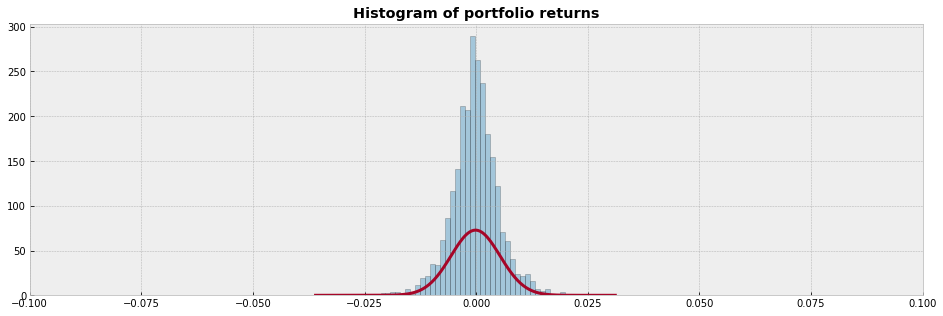

In [7]:
fig = plt.figure(figsize=(16, 5))

x = np.linspace(portfolio_real_returns_selected.min(), portfolio_real_returns_selected.max(), 200)

sns.distplot(portfolio_real_returns_selected, hist=True, kde=False, 
             bins=60,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

params_norm = ss.norm.fit(portfolio_real_returns_selected)
y_pdf = ss.norm.pdf(x, *params_norm)
plt.plot(x, y_pdf, linewidth=3)

plt.title("Histogram of portfolio returns", weight="bold")
plt.xlim([-0.1, 0.1])

plt.show()

наблюдается скошенность влево и более тяжелые хвосты.

### 4) Анализ отдельных инструментов. (2.5 балла, по 0.5 за инструмент)

* Подберите для каждого инструмента наиболее подходящее маржинальное распределение. Можно использовать всё, что есть в scipy, а также garch-модель. Обратите внимание, что в случае использования модели среднего в 
* Для каждого результата изобразите калибровочную кривую (qq-plot), а также наложите оценённую функцию плотности на гистограмму распределения доходности. Обратите внимание, что для GARCH-модели распределение остатков стандартизировано, поэтому для визуализации придётся оценить модель и получить её остатки, а не накладывать плотность GARCH на исходные доходности.
* NB! Постарайтесь подобрать распределение как можно точнее, от этого существенно зависит итоговый результат.

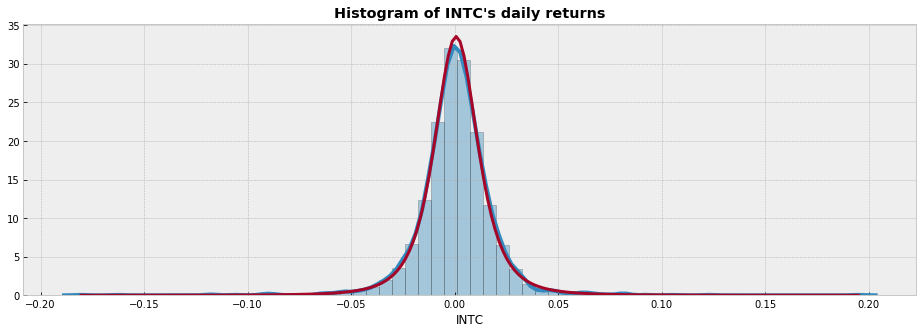

In [8]:
# подбор подходящего распределения для Intel.
fig = plt.figure(figsize=(16, 5))

x = np.linspace(returns['INTC'].min(), returns['INTC'].max(), 200)

sns.distplot(returns['INTC'], hist=True, kde=True, 
                 bins=60,
                 hist_kws={'edgecolor':'black'},
                 kde_kws={'linewidth': 4})

# доходность Intel хорошо описывается Стьюдентом. 
params_t = ss.t.fit(returns['INTC'])
y_pdf = ss.t.pdf(x, *params_t)
plt.plot(x, y_pdf, linewidth=3)

plt.title("Histogram of INTC's daily returns", weight="bold")

plt.show()

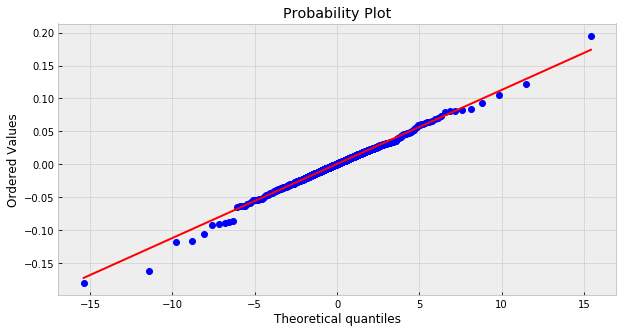

In [9]:
fig = plt.figure(figsize=(10, 5))

ss.probplot(returns['INTC'], dist=ss.nct(*params_t), plot=plt)

plt.show()

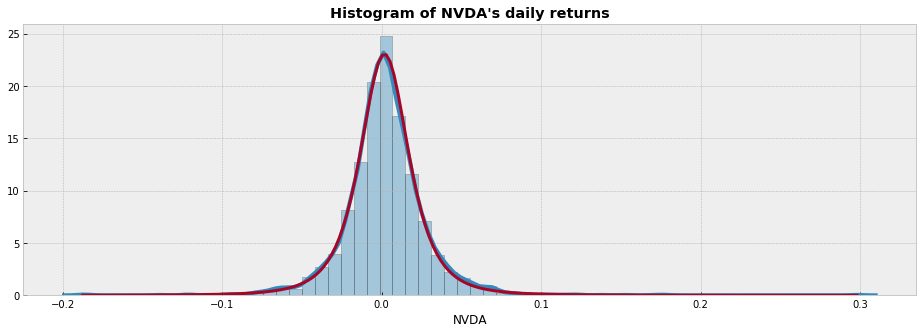

In [10]:
# подбор подходящего распределения для Nvidia.
fig = plt.figure(figsize=(16, 5))

x = np.linspace(returns['NVDA'].min(), returns['NVDA'].max(), 200)

sns.distplot(returns['NVDA'], hist=True, kde=True, 
                 bins=60,
                 hist_kws={'edgecolor':'black'},
                 kde_kws={'linewidth': 4})

# доходность Nvidia имеет распределение Стьюдента. 
params_t = ss.t.fit(returns['NVDA'])
y_pdf = ss.t.pdf(x, *params_t)
plt.plot(x, y_pdf, linewidth=3)

plt.title("Histogram of NVDA's daily returns", weight="bold")

plt.show()

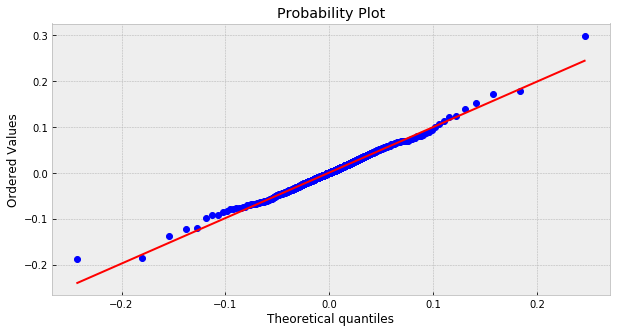

In [11]:
fig = plt.figure(figsize=(10, 5))

ss.probplot(returns['NVDA'], dist=ss.t(*params_t), plot=plt)

plt.show()

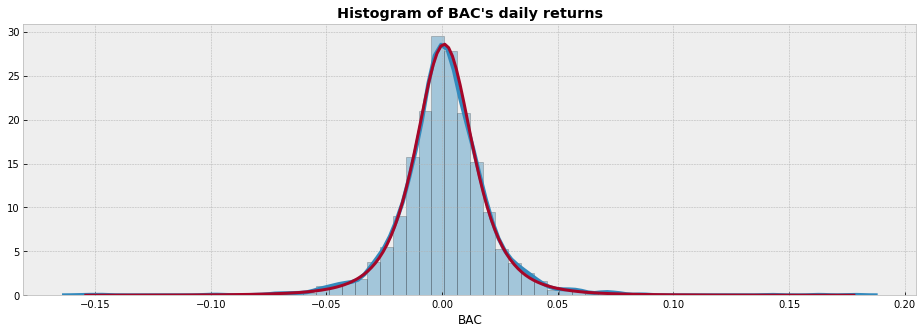

In [12]:
# подбор подходящего распределения для Bank of America.
fig = plt.figure(figsize=(16, 5))

x = np.linspace(returns['BAC'].min(), returns['BAC'].max(), 200)

sns.distplot(returns['BAC'], hist=True, kde=True, 
                 bins=60,
                 hist_kws={'edgecolor':'black'},
                 kde_kws={'linewidth': 4})

# доходность Модерны имеет распределение Стьюдента. 
params_t = ss.t.fit(returns['BAC'])
y_pdf = ss.t.pdf(x, *params_t)
plt.plot(x, y_pdf, linewidth=3)

plt.title("Histogram of BAC's daily returns", weight="bold")

plt.show()

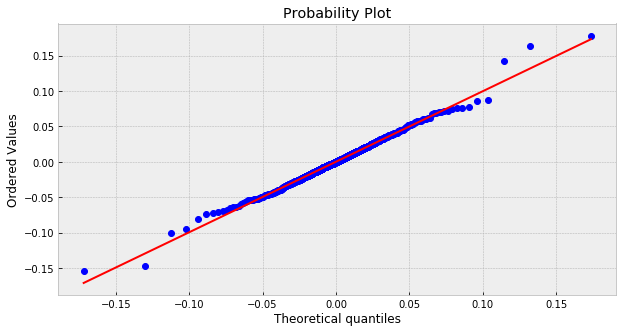

In [13]:
fig = plt.figure(figsize=(10, 5))

ss.probplot(returns['BAC'], dist=ss.t(*params_t), plot=plt)

plt.show()

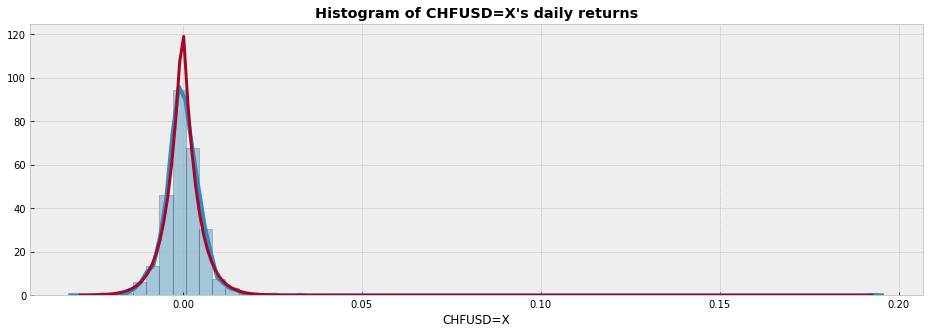

In [14]:
# подбор подходящего распределения для курса франка к доллару.
fig = plt.figure(figsize=(16, 5))

x = np.linspace(returns['CHFUSD=X'].min(), returns['CHFUSD=X'].max(), 200)

sns.distplot(returns['CHFUSD=X'], hist=True, kde=True, 
                 bins=60,
                 hist_kws={'edgecolor':'black'},
                 kde_kws={'linewidth': 4})

# доходность курса франка к доллару хорошо описывается обобщенным нормальным распределением. 
params_gennorm = ss.gennorm.fit(returns['CHFUSD=X'])
y_pdf = ss.gennorm.pdf(x, *params_gennorm)
plt.plot(x, y_pdf, linewidth=3)

plt.title("Histogram of CHFUSD=X's daily returns", weight="bold")

plt.show()

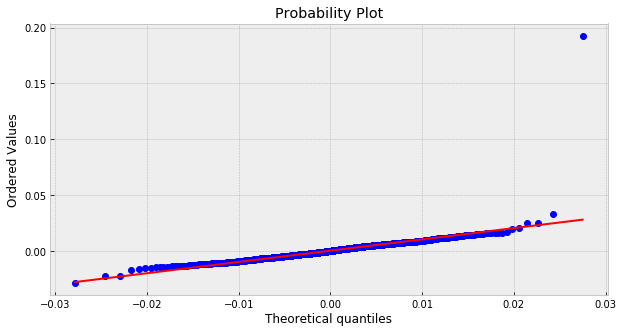

In [15]:
fig = plt.figure(figsize=(10, 5))

ss.probplot(returns['CHFUSD=X'], dist=ss.gennorm(*params_gennorm), plot=plt)

plt.show()

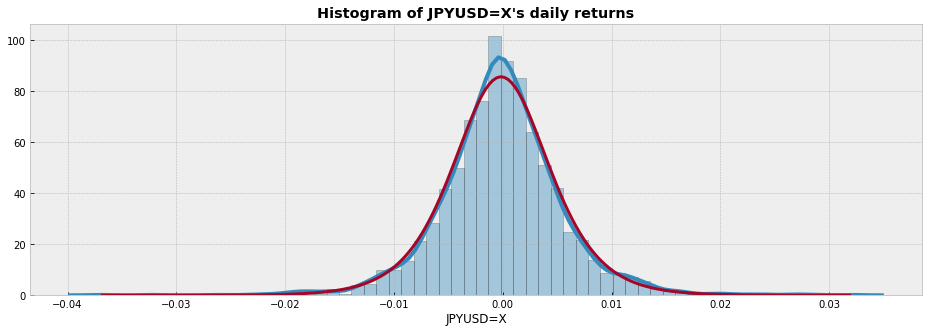

In [16]:
# подбор подходящего распределения для курса йены к доллару.
fig = plt.figure(figsize=(16, 5))

x = np.linspace(returns['JPYUSD=X'].min(), returns['JPYUSD=X'].max(), 200)

sns.distplot(returns['JPYUSD=X'], hist=True, kde=True, 
                 bins=60,
                 hist_kws={'edgecolor':'black'},
                 kde_kws={'linewidth': 4})

# доходность курса йены к доллару хорошо описывается логистическим распределением. 
params_gennorm = ss.logistic.fit(returns['JPYUSD=X'])
y_pdf = ss.logistic.pdf(x, *params_gennorm)
plt.plot(x, y_pdf, linewidth=3)

plt.title("Histogram of JPYUSD=X's daily returns", weight="bold")

plt.show()

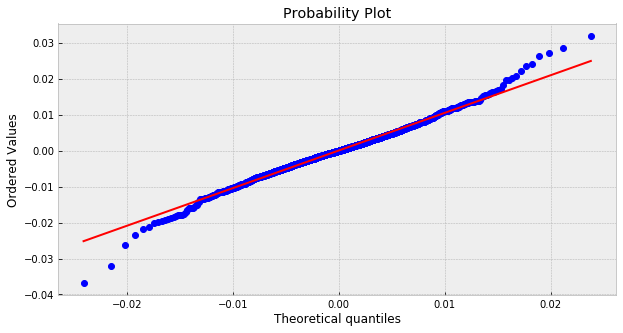

In [17]:
fig = plt.figure(figsize=(10, 5))

ss.probplot(returns['JPYUSD=X'], dist=ss.logistic(*params_gennorm), plot=plt)

plt.show()

### 5) Копулы (1.5 балла)

* Определитесь с количеством копул. Так как наш пример не очень большой размерности, можно обойтись одной копулой на все инструменты сразу. Но если они не связаны (например, Российские акции и какие-нибудь скандинавские валюты), повышать разменость копулы может быть бессмысленно. В таком случае можно попробовать построить две копулы: одну на акции, другую на валюты. 

* Проведите преобразование, переводящее доходности на единичный куб. Воспользуйтесь функциями распределения из пункта 4. Опять же, обратите внимание, что GARCH необходимо обрабатывать отдельно.

* Для каждого случая отберите наилучшую по AIC копулу из Архимедовых. Архимедовыми копулами ограничимся с целью ускорения будущих расчётов. Оценивайте

In [18]:
stocks = ['INTC', 'NVDA', 'BAC']
currencies = ['CHFUSD=X', 'JPYUSD=X']

cdfs = returns.copy()
distribution_params = {}

for col in cdfs[stocks].columns:
    t_df, t_mean, t_sigma = ss.t.fit(cdfs[col])
    distribution_params[col] = (t_df, t_mean, t_sigma)
    cdfs[col] = ss.t.cdf(cdfs[col], df=t_df, loc=t_mean, scale=t_sigma)

# оцененные параметры для курса франк/доллар.
beta, gennorm_mean, gennorm_sigma = ss.gennorm.fit(cdfs['CHFUSD=X'])
cdfs['CHFUSD=X'] = ss.gennorm.cdf(cdfs['CHFUSD=X'], beta=beta, loc=gennorm_mean, scale=gennorm_sigma)  

# оцененные параметры для курса йена/доллар.
logistic_mean, logistic_sigma = ss.logistic.fit(cdfs['JPYUSD=X'])
cdfs['JPYUSD=X'] = ss.logistic.cdf(cdfs['JPYUSD=X'], loc=logistic_mean, scale=logistic_sigma)  

### Copula for stocks 

In [19]:
# обучение ClaytonCopula
clayton_stock = ClaytonCopula(dim=cdfs[stocks].shape[1])
res_clayton_stock = clayton_stock.fit(cdfs[stocks])

# обучение FrankCopula
frank_stock = FrankCopula(dim = cdfs[stocks].shape[1])
res_frank_stock = frank_stock.fit(cdfs[stocks])

# обучение GumbellCopula
gumbell_stock = GumbelCopula(dim = cdfs[stocks].shape[1])
res_gumbell_stock = gumbell_stock.fit(cdfs[stocks])

# выбор лучшей по лог-правдоподобию. Чем выше, тем лучше. 
print('ClaytonCopula log_likelihood:', res_clayton_stock.log_lik(cdfs[stocks]))
print('FrankCopula log_likelihood:', res_frank_stock.log_lik(cdfs[stocks]))
print('GumbellCopula log_likelihood:', res_gumbell_stock.log_lik(cdfs[stocks]))

              INTC         NVDA          BAC
count  2509.000000  2509.000000  2509.000000
mean      0.500000     0.500000     0.500000
std       0.288617     0.288618     0.288617
min       0.000398     0.000398     0.000398
25%       0.250199     0.250199     0.250199
50%       0.500000     0.500000     0.500000
75%       0.749801     0.749801     0.749801
max       0.999602     0.999602     0.999602
              INTC         NVDA          BAC
count  2509.000000  2509.000000  2509.000000
mean      0.500000     0.500000     0.500000
std       0.288617     0.288618     0.288617
min       0.000398     0.000398     0.000398
25%       0.250199     0.250199     0.250199
50%       0.500000     0.500000     0.500000
75%       0.749801     0.749801     0.749801
max       0.999602     0.999602     0.999602
              INTC         NVDA          BAC
count  2509.000000  2509.000000  2509.000000
mean      0.500000     0.500000     0.500000
std       0.288617     0.288618     0.288617
min       

### Copula for currencies 

In [20]:
# обучение ClaytonCopula
clayton_curr = ClaytonCopula(dim=cdfs[currencies].shape[1])
res_clayton_curr = clayton_curr.fit(cdfs[currencies])

# обучение FrankCopula
frank_curr = FrankCopula(dim = cdfs[currencies].shape[1])
res_frank_curr = frank_curr.fit(cdfs[currencies])

# обучение GumbellCopula
gumbell_curr = GumbelCopula(dim = cdfs[currencies].shape[1])
res_gumbell_curr = gumbell_curr.fit(cdfs[currencies])

# выбор лучшей по лог-правдоподобию. Чем выше, тем лучше. 
print('ClaytonCopula log_likelihood:', res_clayton_curr.log_lik(cdfs[currencies]))
print('FrankCopula log_likelihood:', res_frank_curr.log_lik(cdfs[currencies]))
print('GumbellCopula log_likelihood:', res_gumbell_curr.log_lik(cdfs[currencies]))

          CHFUSD=X     JPYUSD=X
count  2509.000000  2509.000000
mean      0.500000     0.500000
std       0.288618     0.288618
min       0.000398     0.000398
25%       0.250199     0.250199
50%       0.500000     0.500000
75%       0.749801     0.749801
max       0.999602     0.999602
          CHFUSD=X     JPYUSD=X
count  2509.000000  2509.000000
mean      0.500000     0.500000
std       0.288618     0.288618
min       0.000398     0.000398
25%       0.250199     0.250199
50%       0.500000     0.500000
75%       0.749801     0.749801
max       0.999602     0.999602
          CHFUSD=X     JPYUSD=X
count  2509.000000  2509.000000
mean      0.500000     0.500000
std       0.288618     0.288618
min       0.000398     0.000398
25%       0.250199     0.250199
50%       0.500000     0.500000
75%       0.749801     0.749801
max       0.999602     0.999602
ClaytonCopula log_likelihood: 239.83009472799233
FrankCopula log_likelihood: 287.09782414569514
GumbellCopula log_likelihood: 311.091648

In [30]:
n_samples = 10 ** 4

# используем лучшую из копул для валют. 
copula_simulations_curr = gumbell_curr.random(n_samples, seed=42)
# лучшая копула для акций
copula_simulations_stock = gumbell_stock.random(n_samples, seed=42)


copula_simulations_curr = pd.DataFrame(copula_simulations_curr, columns=cdfs[currencies].columns)

return_simulations_curr = copula_simulations_curr.copy()

return_simulations_curr['CHFUSD=X'] = ss.gennorm.ppf(copula_simulations_curr['CHFUSD=X'], beta=beta, loc=gennorm_mean, scale=gennorm_sigma)
return_simulations_curr['JPYUSD=X'] = ss.logistic.ppf(copula_simulations_curr['JPYUSD=X'], loc=logistic_mean, scale=logistic_sigma)  

return_simulations_stock = copula_simulations_stock.copy()

for col in cdfs[stocks].columns:
    t_df, t_mean, t_sigma = distribution_params[col]
    return_simulations_stock[col] = ss.t.ppf(copula_simulations_stock[col], df=t_df, loc=t_mean, scale=t_sigma)
    
# объединяем симуляции в одну табличку.
copula_simulations = pd.concat([copula_simulations_curr, copula_simulations_stock], axis = 1)
return_simulations = pd.concat([return_simulations_curr, return_simulations_stock], axis=1)

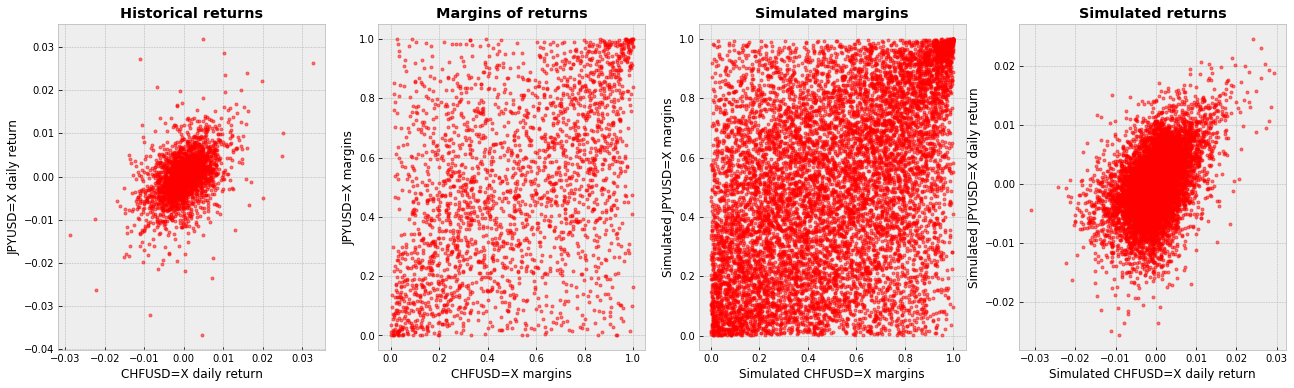

In [34]:
ticker_one = 'CHFUSD=X'
ticker_two = 'JPYUSD=X'

fig = plt.figure(figsize=(22, 6))

plt1 = fig.add_subplot(1,4,1)
plt2 = fig.add_subplot(1,4,2)
plt3 = fig.add_subplot(1,4,3)
plt4 = fig.add_subplot(1,4,4)

my_lim = 0.08
idx = (np.abs(returns[ticker_one]) < my_lim) & (np.abs(returns[ticker_two]) < my_lim)
x = returns.loc[idx, ticker_one]
y = returns.loc[idx, ticker_two]
plt1.plot(x, y, "r.", alpha=0.5)

plt1.set_xlabel("{} daily return".format(ticker_one))
plt1.set_ylabel("{} daily return".format(ticker_two))
plt1.set_title("Historical returns", weight="bold")


x = cdfs[ticker_one]
y = cdfs[ticker_two]
plt2.plot(x, y, "r.", alpha=0.5)

plt2.set_xlabel("{} margins".format(ticker_one))
plt2.set_ylabel("{} margins".format(ticker_two))
plt2.set_title("Margins of returns", weight="bold")


x = copula_simulations[ticker_one]
y = copula_simulations[ticker_two]
plt3.plot(x, y, "r.", alpha=0.5)

plt3.set_xlabel("Simulated {} margins".format(ticker_one))
plt3.set_ylabel("Simulated {} margins".format(ticker_two))
plt3.set_title("Simulated margins", weight="bold")


my_lim = 0.1
idx = (np.abs(return_simulations[ticker_one]) < my_lim) & (np.abs(return_simulations[ticker_two]) < my_lim)
x = return_simulations.loc[idx, ticker_one]
y = return_simulations.loc[idx, ticker_two]
plt4.plot(x, y, "r.", alpha=0.5)

plt4.set_xlabel("Simulated {} daily return".format(ticker_one))
plt4.set_ylabel("Simulated {} daily return".format(ticker_two))
plt4.set_title("Simulated returns", weight="bold")

plt.show()

### 6) VaR и ES (2.5 балла)

С помощью выбранных распределений и копул постройте VaR-кривую и ES-кривую. Можете пользоваться функциями с семинара и модифицировать их по необходимости. 

In [48]:
portfolio_simulated_returns = np.dot(return_simulations.values, w_temp)

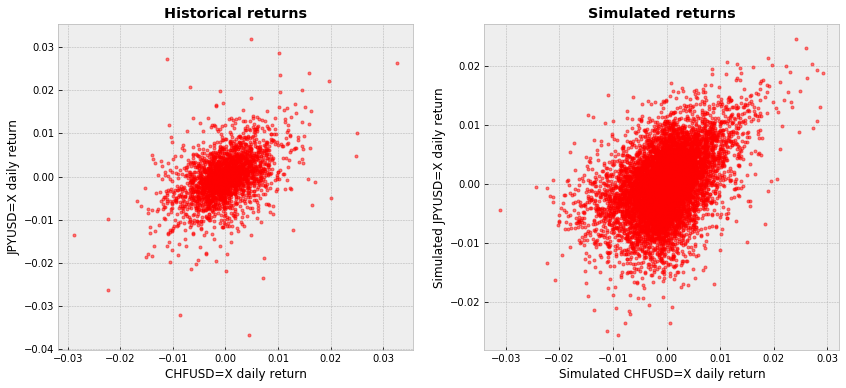

In [47]:
fig = plt.figure(figsize=(14, 6))

plt1 = fig.add_subplot(1,2,1)
plt2 = fig.add_subplot(1,2,2)

my_lim = 0.08
idx = (np.abs(returns[ticker_one]) < my_lim) & (np.abs(returns[ticker_two]) < my_lim)
x = returns.loc[idx, ticker_one]
y = returns.loc[idx, ticker_two]
plt1.plot(x, y, "r.", alpha=0.5)

plt1.set_xlabel("{} daily return".format(ticker_one))
plt1.set_ylabel("{} daily return".format(ticker_two))
plt1.set_title("Historical returns", weight="bold")

my_lim = 0.1
idx = (np.abs(return_simulations[ticker_one]) < my_lim) & (np.abs(return_simulations[ticker_two]) < my_lim)
x = return_simulations.loc[idx, ticker_one]
y = return_simulations.loc[idx, ticker_two]
plt2.plot(x, y, "r.", alpha=0.5)

plt2.set_xlabel("Simulated {} daily return".format(ticker_one))
plt2.set_ylabel("Simulated {} daily return".format(ticker_two))
plt2.set_title("Simulated returns", weight="bold")

plt.show()

In [36]:
def calculate_VaR_HS(ret, alpha=0.05):

    return ret.quantile(alpha)


def calc_VaR(r, VaR_fun, L_history=252, level=0.05):
    VaR = np.full(r.size, np.nan)
    
    for i in range(L_history, len(r)):
        history = r[i - L_history: i]
        VaR[i] = VaR_fun(history, level)
        
    return pd.Series(data=VaR, index=r.index, name=VaR_fun.__name__)

### 7) Визуализация (0.4 балла)

Визуализируйте VaR и ES на графике с доходностями.

In [ ]:
# ༼ つ ◕_◕ ༽つ

### 8) Бектестинг. (0.4 балла)

Проведите тесты на покрытие и независимость для VAR-кривой. Удалось ли пройти эти тесты?

In [ ]:
# ༼ つ ◕_◕ ༽つ

##### Рубрика "как вам домашка?"
Поделитесь, что вам понравилось, а что нет. Это важно